# Number plate petection and recognition
In this notebook I desing custom model for car number plate detection and later use pytesseract to read number plate into text.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import xml.etree.ElementTree as ET
import albumentations as alb
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pytesseract

## Importing and preprocessing data

In [2]:
path = glob("ANPR.v2i.voc/*/*.xml")
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for file in path:
    tree = ET.parse(file)
    root = tree.getroot()
    member_obj = root.find('object')
    bndbox = member_obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)

    labels_dict['filepath'].append(file)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,ANPR.v2i.voc\test\105_jpg.rf.19add5d0fb7022444...,381,712,681,836
1,ANPR.v2i.voc\test\124_jpg.rf.47cb266f845ec0579...,529,649,795,836
2,ANPR.v2i.voc\test\130_jpg.rf.0847c685a66d5ce18...,142,267,705,872
3,ANPR.v2i.voc\test\133_jpg.rf.fca4ddb34ba6aa299...,101,333,620,791
4,ANPR.v2i.voc\test\170_jpg.rf.a60783258f5e3c9e5...,172,499,940,988


In [4]:
def getFilename(filename):
    filename_image = ET.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('ANPR.v2i.voc/*/',filename_image)
    return filepath_image

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:5]

['ANPR.v2i.voc/*/105_jpg.rf.19add5d0fb70224447057d2ea8a4eea6.jpg',
 'ANPR.v2i.voc/*/124_jpg.rf.47cb266f845ec0579fd51e5e63fc1be8.jpg',
 'ANPR.v2i.voc/*/130_jpg.rf.0847c685a66d5ce18485ef7b49e85668.jpg',
 'ANPR.v2i.voc/*/133_jpg.rf.fca4ddb34ba6aa29930cea882d67f4b8.jpg',
 'ANPR.v2i.voc/*/170_jpg.rf.a60783258f5e3c9e5f0270df64cac4e1.jpg']

In [6]:
labels = df.iloc[:,1:].values
data = []
target = []

for index in range(len(image_path)):
    img = image_path[index]
    img = glob(img)
    img_arr = cv2.imread(img[0])
    height, width, depth = img_arr.shape
    loaded_img = load_img(img[0],target_size=(224,224))
    loaded_img_arr = img_to_array(loaded_img)
    loaded_img_arr_norm = loaded_img_arr/255.0
    xmin,xmax,ymin,ymax = labels[index]
    xmin_norm = xmin/width
    xmax_norm = xmax/width
    ymin_norm = ymin/height
    ymax_norm = ymax/height
    labels_norm = (xmin_norm,xmax_norm,ymin_norm,ymax_norm)
    data.append(loaded_img_arr_norm)
    target.append(labels_norm)

## Visualizing data
On the image below we can see one of images from our test data with drawn bounding box. This visualization should give an idea of how well trained model should predict bounding boxes for license plates.

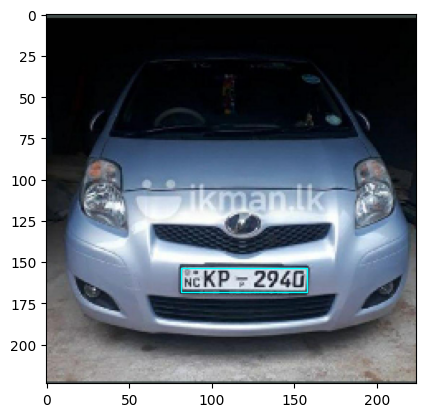

In [7]:
plt.imshow(data[10])
xmin, xmax, ymin, ymax = target[10]
rect = Rectangle((xmin*224, ymin*224), xmax*224 - xmin*224, ymax*224 - ymin*224, linewidth=1, edgecolor='cyan', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

## Splitting data
For training purpouses we will use 80% of data and the other 20% will be our test data.

In [8]:
X = np.array(data,dtype=np.float32)
y = np.array(target,dtype=np.float32)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Creating model
To tackle this problem we will use CNN. As our model we will use pretrained convutional base of InceptionResNetV2 with custom made top.

In [10]:
resnet = InceptionResNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

model_top = resnet.output
model_top = Flatten()(model_top)
model_top = Dense(500,activation='relu')(model_top)
model_top = Dropout(0.5)(model_top)
model_top = Dense(250,activation='relu')(model_top)
model_top = Dropout(0.5)(model_top)
model_top = Dense(4,activation='sigmoid')(model_top)

model = Model(inputs = resnet.input,outputs=model_top)

In [11]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate= 0.000035))

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#!tensorboard --logdir=E:\Computer_Vision\ANPR_new\object_detection/train

## Model training
Now lets train our model and check the results.

In [14]:
tfb = TensorBoard('object_detection')
history = model.fit(x=X_train,y=y_train,batch_size=8,epochs=100,
                    validation_data=(X_test,y_test),
                    callbacks=[tfb,EarlyStopping(patience=5)])

Epoch 1/100
155/155 [==============================] - 86s 420ms/step - loss: 0.0419 - val_loss: 0.0188
Epoch 2/100
155/155 [==============================] - 67s 435ms/step - loss: 0.0217 - val_loss: 0.0166
Epoch 3/100
155/155 [==============================] - 65s 420ms/step - loss: 0.0162 - val_loss: 0.0136
Epoch 4/100
155/155 [==============================] - 64s 416ms/step - loss: 0.0139 - val_loss: 0.0115
Epoch 5/100
155/155 [==============================] - 67s 432ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 6/100
155/155 [==============================] - 65s 417ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 7/100
155/155 [==============================] - 66s 423ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 8/100
155/155 [==============================] - 73s 469ms/step - loss: 0.0085 - val_loss: 0.0098
Epoch 9/100
155/155 [==============================] - 76s 486ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 10/100
155/155 [==============================] - 71s 457m

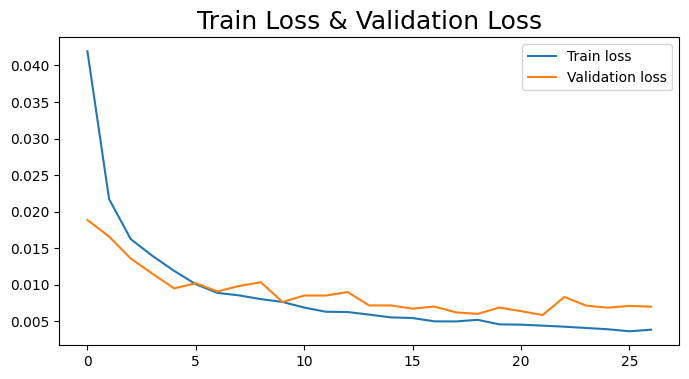

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Train Loss & Validation Loss',fontsize=18)
plt.legend()


## Visualization of predictions
Lets see how model performs on unseen data.

In [18]:
path = 'TEST/20180402113123_NumberPlate_Swift.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 570
Width of the image = 870


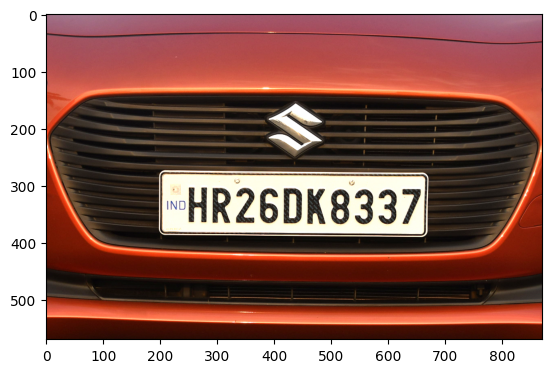

In [19]:
fig = plt.imshow(image)

In [20]:
image_arr_224.shape

(224, 224, 3)

In [21]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [22]:
coords = model.predict(test_arr)
coords

array([[0.2648917 , 0.75959826, 0.42419624, 0.6652388 ]], dtype=float32)

In [23]:
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[230.45579106, 660.85048199, 241.79185867, 379.18611467]])

In [24]:
coords = coords.astype(np.int32)
coords

array([[230, 660, 241, 379]])

In [25]:
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(230, 241) (660, 379)


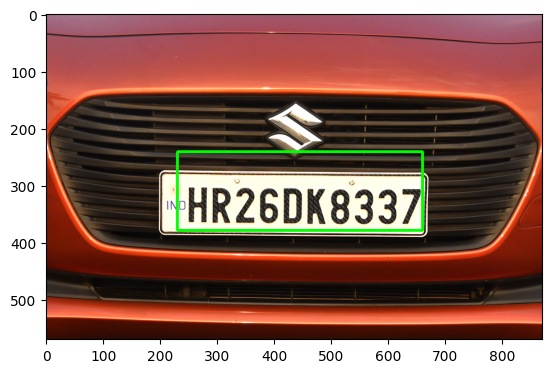

In [26]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = plt.imshow(image)


As we can see model draws bounding box around license plate but we need to remember that this test photo is not a real life scenario test case. We can now use this prediction to demonstrate usage of pytesseract to read this license plate into text.

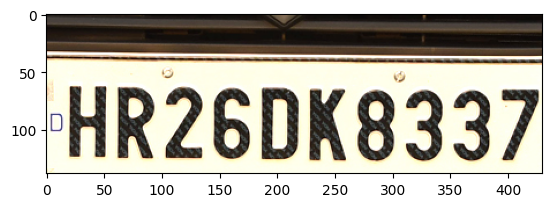

In [27]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = coords[0]
roi = img[ymin:ymax,xmin:xmax]
fig = plt.imshow(roi)

In [28]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [29]:
text = pytesseract.image_to_string(roi)
print(text)

HR26DK8337


